In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras_tuner import RandomSearch

2025-01-21 14:53:16.080712: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-21 14:53:16.084761: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-21 14:53:16.096431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737471196.115640  297489 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737471196.121172  297489 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 14:53:16.142725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# 0. Data

In [2]:
file_path="../data/ozone_complet.csv"
df = pd.read_csv(file_path, sep=";", decimal=',')

In [3]:
df

,date,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
0,19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
1,19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
2,19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
3,19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
4,19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,20020926,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
1460,20020927,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
1461,20020928,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0
1462,20020929,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,...,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0


In [4]:
df.isna().sum()

date       0
maxO3     73
T6         1
T9         1
T12        1
T15        1
T18        1
Ne6        2
Ne9        2
Ne12       2
Ne15       2
Ne18       5
Vdir6      1
Vvit6      1
Vdir9      1
Vvit9      1
Vdir12     1
Vvit12     1
Vdir15     1
Vvit15     1
Vdir18     1
Vvit18     1
Vx         1
maxO3v    73
dtype: int64

In [5]:
df.dropna(inplace=True)
df.drop("date", inplace=True, axis=1)

In [6]:
# Exemple : Convertir toutes les colonnes en types numériques
df = df.apply(pd.to_numeric, errors='coerce')

# Vérification des types après conversion
print(df.dtypes)
print(df.shape)

maxO3     float64
T6        float64
T9        float64
T12       float64
T15       float64
T18       float64
Ne6       float64
Ne9       float64
Ne12      float64
Ne15      float64
Ne18      float64
Vdir6     float64
Vvit6     float64
Vdir9     float64
Vvit9     float64
Vdir12    float64
Vvit12    float64
Vdir15    float64
Vvit15    float64
Vdir18    float64
Vvit18    float64
Vx        float64
maxO3v    float64
dtype: object
(1366, 23)


# 1. Pre-processing

In [7]:
# Données
X = df.drop("maxO3v", axis=1)  # Features
y = df["maxO3v"]  # Cible

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Division en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X shape: (1366, 22)
y shape: (1366,)


# 2. Modeling

In [8]:
# Définir le modèle pour Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    # Nombre de couches cachées à optimiser
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=8, max_value=128, step=8),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        ))
    # Couche de sortie
    model.add(tf.keras.layers.Dense(1, activation='linear'))  # Régression
    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mse',  # Erreur quadratique moyenne pour la régression
        metrics=['mae']  # Erreur absolue moyenne
    )
    return model

# Configuration du tuner
tuner = RandomSearch(
    build_model,
    objective='val_mae',  # Minimiser l'erreur absolue moyenne
    max_trials=20,  # Nombre total d'essais
    executions_per_trial=1,  # Exécuter une seule fois chaque configuration
    directory='keras_tuner',
    project_name='optimal_layers_neurons'
)

# Recherche d'hyperparamètres
tuner.search(
    X_train_scaled, y_train,
    validation_split=0.1,  # 10% des données d'entraînement utilisées pour la validation
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=0
)

# Résultats du tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres trouvés :")
print(f"Nombre de couches : {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"  - Neurones dans la couche {i + 1} : {best_hps.get(f'units_{i}')}")
print(f"Activation : {best_hps.get('activation')}")
print(f"Taux d'apprentissage : {best_hps.get('lr')}")

2025-01-21 14:53:18.330365: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Meilleurs hyperparamètres trouvés :
Nombre de couches : 2
  - Neurones dans la couche 1 : 88
  - Neurones dans la couche 2 : 72
Activation : sigmoid
Taux d'apprentissage : 0.008075139307516212


In [9]:
# Reconstruire le modèle avec les meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

# Entraîner le modèle sur l'ensemble d'entraînement complet
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,  # Optionnel, pour voir la performance sur une partie de l'entraînement
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

# Évaluer le modèle sur l'ensemble de test
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=1)

# Afficher les résultats
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")


Epoch 1/50


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6509.6714 - mae: 77.3583 - val_loss: 5328.3447 - val_mae: 68.7639
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4402.7202 - mae: 62.2158 - val_loss: 3675.6838 - val_mae: 55.4597
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2916.4019 - mae: 48.9754 - val_loss: 2421.0161 - val_mae: 42.7246
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1943.1683 - mae: 37.3534 - val_loss: 1616.8693 - val_mae: 32.5312
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1380.4629 - mae: 29.5296 - val_loss: 1153.1045 - val_mae: 25.7508
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 891.5645 - mae: 22.2560 - val_loss: 877.6329 - val_mae: 21.6676
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 746.5768 - mae: 20.2662 - val_loss: 713.5067 - val_mae: 19.4068
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 576.5872 - mae: 18.0592 - val_loss: 645.4537 - val_mae: 18.7067
Epoch 9/50
35/35 ━━━━━━━━

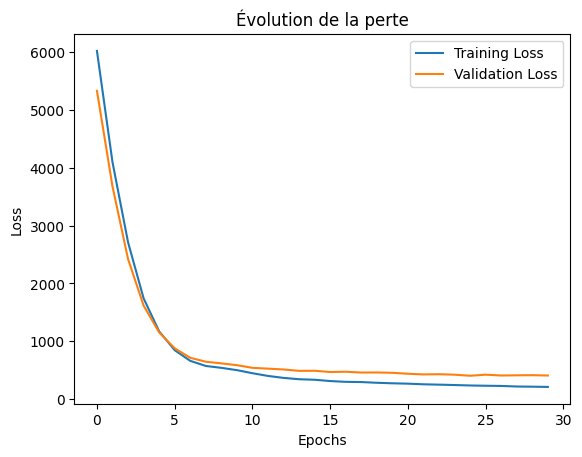

In [10]:
import matplotlib.pyplot as plt

# Tracer l'évolution de la perte
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Évolution de la perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
